In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
from scipy import interpolate, integrate
from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib as mpl
rc('font',size=18)

In [3]:
NDIM = 3

In [4]:
rin = 0
rout = 5
#rout = 200
N1D = 200
grid1d = np.linspace(rin, rout, N1D)
dr1d = grid1d[1] - grid1d[0]

In [219]:
def pseudo2(r, dr):
    return np.maximum(dr*dr*np.ones_like(r), r**2)

def get_y(r, sigma):
    return np.exp(-(r/(2*sigma))**2)

def make_X_global(bounds, nx):
    xf_global = []
    xc_global = []
    dx = []
    for i in range(NDIM):
        # faces without ghosts
        xf = np.linspace(bounds[i][0],bounds[i][1],nx[i]+1)
        dx.append(xf[1] - xf[0])
        # incorporate ghost zones
        xf = np.linspace(bounds[i][0], 
                         bounds[i][1], 
                         nx[i] + 1)
        xc = 0.5*(xf[1:] + xf[:-1])
        xf_global.append(xf)
        xc_global.append(xc)
    Xf_global = np.meshgrid(*xf_global, indexing='ij')
    Xc_global = np.meshgrid(*xc_global, indexing='ij')
    
    return Xf_global, Xc_global, dx

def make_X_blocks(Xf_global, Xc_global, nx, nb):
    nx_b = [(n//d) for n,d in zip(nx,nb)]
    Xf_blks = np.empty((nb[0],nb[1],nb[2],NDIM,nx_b[0]+1,nx_b[1]+1,nx_b[2]+1))
    Xc_blks = np.empty((nb[0],nb[1],nb[2],NDIM,nx_b[0],nx_b[1],nx_b[2]))
    for ib in range(nb[0]):
        for jb in range(nb[1]):
            for kb in range(nb[2]):
                for d in range(NDIM):
                    Xf_blks[ib,jb,kb,d] = Xf_global[d][nx_b[0]*ib:nx_b[0]*(ib+1)+1,
                                                       nx_b[1]*jb:nx_b[1]*(jb+1)+1,
                                                       nx_b[2]*kb:nx_b[2]*(kb+1)+1]
                    Xc_blks[ib,jb,kb,d] = Xc_global[d][nx_b[0]*ib:nx_b[0]*(ib+1),
                                                       nx_b[1]*jb:nx_b[1]*(jb+1),
                                                       nx_b[2]*kb:nx_b[2]*(kb+1)]
    return Xf_blks, Xc_blks, nx_b

def refine_block(Xf, Xc):
    nb = (2, 2, 2)
    nx = (nb[0]*Xc.shape[1], 
          nb[1]*Xc.shape[2], 
          nb[2]*Xc.shape[3])
    nx_b = Xc.shape[1:]
    bounds = [[Xf[0,0,0,0], Xf[0,-1,0,0]],
              [Xf[1,0,0,0], Xf[1,0,-1,0]],
              [Xf[2,0,0,0], Xf[2,0,0,-1]]]
    Xf_global, Xc_global, nx = make_X_global(bounds,nx)
    Xf_new = []
    Xc_new = []
    for ib in range(nb[0]):
        for jb in range(nb[1]):
            for kb in range(nb[2]):
                Xf_loc = []
                Xc_loc = []
                for d in range(NDIM):
                    Xf_loc.append(Xf_global[d][nx_b[0]*ib:nx_b[0]*(ib+1)+1,
                                               nx_b[1]*jb:nx_b[1]*(jb+1)+1,
                                               nx_b[2]*kb:nx_b[2]*(kb+1)+1])
                    Xc_loc.append(Xc_global[d][nx_b[0]*ib:nx_b[0]*(ib+1),
                                               nx_b[1]*jb:nx_b[1]*(jb+1),
                                               nx_b[2]*kb:nx_b[2]*(kb+1)])
                Xf_new.append(np.stack(Xf_loc))
                Xc_new.append(np.stack(Xc_loc))
    return Xf_new, Xc_new

def refine_and_flatten_blocks(Xf_blks, Xc_blks, blocks_to_refine = None):
    Xf_out = []
    Xc_out = []
    for ib in range(Xc_blks.shape[0]):
        for jb in range(Xc_blks.shape[1]):
            for kb in range(Xc_blks.shape[2]):
                if blocks_to_refine is not None and [ib,jb,kb] in blocks_to_refine:
                    Xf_new, Xc_new = refine_block(Xf_blks[ib,jb,kb],Xc_blks[ib,jb,kb])
                    Xf_out += Xf_new
                    Xc_out += Xc_new
                else:
                    Xf_out.append(Xf_blks[ib,jb,kb])
                    Xc_out.append(Xc_blks[ib,jb,kb])
    return np.stack(Xf_out), np.stack(Xc_out)

def get_coords_sph(Xc_blks, cartesian = False):
    if cartesian:
        r_blks = np.sqrt(Xc_blks[:,0,:,:,:]**2 + Xc_blks[:,1,:,:,:]**2 + Xc_blks[:,2,:,:]**2)
        r_blks_cyl = np.sqrt(Xc_blks[:,0,:,:,:]**2 + Xc_blks[:,1,:,:,:]**2)
        th_blks = np.arctan2(Xc_blks[:,2,:,:,:], r_blks_cyl)
        ph_blks = np.arctan2(Xc_blks[:,1,:,:,:], Xc_blks[:,0,:,:,:])
    else:
        r_blks = Xc_blks[:,0,:,:,:]
        th_blks = Xc_blks[:,1,:,:,:]
        ph_blks = Xc_blks[:,2,:,:,:] 
    return r_blks, th_blks, ph_blks

def get_dx_blks(Xf_blks):
    # cell widths defined at faces
    dx1_blks = Xf_blks[:,0,1:,:,:] - Xf_blks[:,0,:-1,:,:]
    dx2_blks = Xf_blks[:,1,:,1:,:] - Xf_blks[:,1,:,:-1,:]
    dx3_blks = Xf_blks[:,2,:,:,1:] - Xf_blks[:,2,:,:,:-1]
    # cell widths defined at cell centers
    dx1_blks  = 0.25*(dx1_blks[:,:,1:,1:] + dx1_blks[:,:,:-1,:-1] 
                     + dx1_blks[:,:,1:,:-1] + dx1_blks[:,:,:-1,1:])
    dx2_blks = 0.25*(dx2_blks[:,1:,:,1:] + dx2_blks[:,:-1,:,:-1]
                     + dx2_blks[:,1:,:,:-1] + dx2_blks[:,:-1,:,1:])
    dx3_blks = 0.25*(dx3_blks[:,1:,1:,:] + dx3_blks[:,:-1,:-1,:]
                     + dx3_blks[:,1:,:-1,:] + dx3_blks[:,:-1,1:,:])
    return dx1_blks, dx2_blks, dx3_blks

def get_dx_sph(Xf_blks, r_blks, th_blks, ph_blks, cartesian = False):
    dx1_blks, dx2_blks, dx3_blks = get_dx_blks(Xf_blks)
    if cartesian:
        r = r_blks
        th = th_blks
        ph = ph_blks
        dx = dx1_blks
        dy = dx2_blks
        dz = dx3_blks
        dr_blks  = dz*np.cos(th) + np.sin(th)*(dx*np.cos(ph) + dy*np.sin(ph))
        dth_blks = r*(-dz*np.sin(th) + np.cos(th)*(dx*np.cos(ph) + dy*np.sin(ph)))
        dph_blks = r*np.sin(th)*(dy*np.cos(ph) - dx*np.sin(ph))
        return dr_blks, dth_blks, dph_blks
    else:
        return dx1_blks, dx2_blks, dx3_blks

def spherically_average_naive(y_monopole, y_blks,
                              Xf_blks, Xc_blks, grid1d, nx_b,
                              cartesian = False,
                              cell_fac = 3):
    dr1d = grid1d[1] - grid1d[0]
    
    r_blks, th_blks, ph_blks = get_coords_sph(Xc_blks, cartesian)
    dr_blks, dth_blks, dph_blks = get_dx_sph(Xf_blks, r_blks, th_blks, ph_blks, cartesian)
    r_faces, th_faces, ph_faces = get_coords_sph(Xf_blks, cartesian)
    
    # r^2 sin(th) dth dph y
    drmin = dr_blks.min()
    y_integrand_blks = r_blks*r_blks*np.sin(th_blks)*dth_blks*dph_blks*y_blks
    y_integrand_blks_alt = ((3*drmin)**2)*np.sin(th_blks)*dth_blks*dph_blks*y_blks
    div_fac = 4*np.pi*pseudo2(grid1d,3*drmin)
     
    y_avgd = np.zeros_like(y_monopole)
    numblocks = Xc_blks.shape[0]
    for ib in range(numblocks):
        face_inner = r_faces[ib].min()
        face_outer = r_faces[ib].max()
        for i in range(nx_b[0]):
            for j in range(nx_b[1]):
                for k in range(nx_b[2]):
                    r0 = r_blks[ib,i,j,k]
                    y0_base = y_integrand_blks[ib,i,j,k]
                    y0_alt = y_integrand_blks_alt[ib,i,j,k]                       
                    dr = dr_blks[ib,i,j,k]
                    bl = r0 - dr
                    br = r0 + dr
                    il = np.where(np.logical_and(grid1d >= bl,grid1d >= face_inner))[0]
                    #il = np.where(grid1d >= bl)[0]
                    if len(il) > 0:
                        il = il[0]
                    else:
                        il = 0
                    ir = np.where(np.logical_or(grid1d > br, grid1d > face_outer))[0]
                    #ir = np.where(grid1d > br)[0]
                    if len(ir) > 0:
                        ir = ir[0]
                    else:
                        ir = len(grid1d)
                    for imono in range(il, ir):
                        r = grid1d[imono]
                        y0 = (y0_alt if np.abs(r) <= cell_fac*dr else y0_base)
                        y_avgd[imono] += y0*max(0,(1 - np.abs(r - r0)/dr))
                        #y_avgd[imono] += y0 if r0 <= dr/2 and r <= dr/2 else y0*max(0,(1 - np.abs(r - r0)/dr))
                            
    y_avgd /= div_fac
    y_avgd[0] = y_avgd[1]
    return y_avgd

def spherically_average_faces(y_monopole, yf_blks, 
                              Xf_blks, Xc_blks,
                              grid1d, nx_b, 
                              cartesian=False, cell_fac=3, eps=0.1):
  
    dr1d = grid1d[1] - grid1d[0]
    
    r_blks, th_blks, ph_blks = get_coords_sph(Xc_blks, cartesian)
    r_faces, th_faces, ph_faces = get_coords_sph(Xf_blks, cartesian)
    dr_blks, dth_blks, dph_blks = get_dx_sph(Xf_blks, r_blks, th_blks, ph_blks, cartesian)
    
    # r^2 sin(th) dth dph y
    drmin = dr_blks.min()
    y_integrand_faces = (r_faces**2)*np.sin(th_faces)*yf_blks
    y_integrand_faces_alt = ((cell_fac*drmin)**2)*np.sin(th_faces)*yf_blks
    div_fac = 4*np.pi*pseudo2(grid1d,cell_fac*drmin)
    
    y_avgd = np.zeros_like(y_monopole)
    numblocks = Xf_blks.shape[0]
    for ib in range(numblocks):
        face_inner = r_faces[ib].min()
        face_outer = r_faces[ib].max()
        for i in range(nx_b[0]):
            for j in range(nx_b[1]):
                for k in range(nx_b[2]):
                    r0 = r_faces[ib,i,j,k]
                    y0_base = y_integrand_faces[ib,i,j,k]
                    y0_alt = y_integrand_faces_alt[ib,i,j,k]
                    dr,dth,dph = dr_blks[ib,i,j,k], dth_blks[ib,i,j,k], dph_blks[ib,i,j,k]
                    bl, br = r0 - dr, r0 + dr
                    il = np.where(np.logical_and(grid1d >= bl, grid1d >= face_inner))[0]
                    il = il[0] if len(il) > 0 else 0
                    ir = np.where(np.logical_or(grid1d > br + eps*dr, grid1d > face_outer + eps*dr))[0]
                    ir = ir[0] if len(ir) > 0 else len(grid1d)
                    for imono in range(il, ir):
                        r = grid1d[imono]
                        y0 = (y0_alt if np.abs(r) <= cell_fac*dr else y0_base)*dth*dph
                        y_avgd[imono] += y0*max(0,(1 - np.abs(r - r0)/dr))
    y_avgd /= div_fac
    y_avgd[0] = y_avgd[1]
    return y_avgd

def in_bounds(a, r0, dr0):
    return np.logical_and(a >= r0 - 0.5*dr0, a < r0 + 0.5*dr0)

def get_vol_intersect(r1d, dr1d, r0, dr0):
    vol_intersect = np.zeros_like(r1d)
    if dr1d <= dr0:
        left_in_bnds = in_bounds(r1d - 0.5*dr1d, r0, dr0)
        right_in_bnds = in_bounds(r1d + 0.5*dr1d, r0, dr0)
        intersection_exists = np.logical_or(left_in_bnds, right_in_bnds)
        interior_mask = np.logical_and(left_in_bnds,right_in_bnds)
        vol_intersect[interior_mask] = dr1d/dr0
        left_mask = np.logical_and(right_in_bnds, np.logical_not(left_in_bnds))
        vol_intersect += left_mask*(r1d + 0.5*dr1d - (r0 - 0.5*dr0))/dr0
        right_mask = np.logical_and(left_in_bnds, np.logical_not(right_in_bnds))
        vol_intersect += right_mask*(r0 + 0.5*dr0 - (r1d - 0.5*dr1d))/dr0
    else:
        raise ValueError("monopole grid must be finer than finest fluid grid. Drs = {}, {}".format(dr1d, dr0))
    return vol_intersect

def spherically_average_mass(y_monopole, y_blks,
                             Xf_blks, Xc_blks,
                             faces1d, centers1d, nx_b,
                             cartesian=False, cell_fac = 3):
    dr1d = grid1d[1] - grid1d[0]

    r_blks, th_blks, ph_blks = get_coords_sph(Xc_blks, cartesian)
    dr_blks, dth_blks, dph_blks = get_dx_sph(Xf_blks, r_blks, th_blks, ph_blks, cartesian)
    r_faces, th_faces, ph_faces = get_coords_sph(Xf_blks, cartesian)
    
    # r^2 sin(th) dth dph y
    v_blks = np.sin(th_blks)*dr_blks*dth_blks*dph_blks*(r_blks**2)
    y_mass_blks = v_blks*y_blks
    #div_fac = 4*np.pi*dr1d

    ycells_avgd = np.zeros_like(centers1d)
    vcells_avgd = np.zeros_like(centers1d)
    y_avgd = np.empty_like(faces1d)
    numblocks = Xf_blks.shape[0]
    for ib in range(numblocks):
        for i in range(nx_b[0]):
            for j in range(nx_b[1]):
                for k in range(nx_b[2]):
                    rc = r_blks[ib,i,j,k]
                    dr,dth,dph = dr_blks[ib,i,j,k], dth_blks[ib,i,j,k], dph_blks[ib,i,j,k]
                    y0 = y_mass_blks[ib,i,j,k]
                    v0 = v_blks[ib,i,j,k]
                    vol_intersects = get_vol_intersect(centers1d, dr1d, rc, dr)
                    ycells_avgd += vol_intersects*y0
                    vcells_avgd += vol_intersects*v0
    #ycells_avgd /= div_fac
    ycells_avgd /= (vcells_avgd + 1e-20)
    y_avgd[1:] = 0.5*(ycells_avgd[1:] + ycells_avgd[:-1])
    y_avgd[0] = ycells_avgd[0]
    return y_avgd

# Container class
class SphericalAverage:
    def __init__(self, rout, n1d, nx, nb,
                 blocks_to_refine = None,
                 avg_type = 'mass',
                 cartesian = False,
                 sigma = 0.5, cell_fac = 3, eps = 0.1):
        rin = 0
        self.rin = rin
        self.rout = rout
        self.n1d = n1d
        self.nx = nx
        self.nb = nb
        self.blocks_to_refine = blocks_to_refine
        self.cartesian = cartesian
        self.sigma = sigma
        self.cell_fac = cell_fac
        
        # generate grids
        print("Generating grids")
        self.grid1d = np.linspace(rin, rout, n1d)
        self.dr1d = self.grid1d[1] - self.grid1d[0]
        self.centers1d = self.grid1d + self.dr1d/2.
        if cartesian:
            self.bounds = [-(rout, rout), (-rout, rout), (-rout, rout)]
        else:
            self.bounds = [(rin,rout), (0, np.pi), (0, 2*np.pi)]
        self.Xf_global, self.Xc_global, self.dx = make_X_global(self.bounds, nx)
        Xf_blks, Xc_blks, self.nx_b = make_X_blocks(self.Xf_global, self.Xc_global, nx, nb)
        self.Xf_blks, self.Xc_blks = refine_and_flatten_blocks(Xf_blks, Xc_blks, blocks_to_refine)
        
        # generate function to interpolate
        print("Generating functions")
        self.y_monopole = get_y(self.grid1d, sigma)
        
        # put it on the 3d mesh
        self.r_blks, _, _ = get_coords_sph(self.Xc_blks, cartesian)
        self.rf_blks, _, _ = get_coords_sph(self.Xf_blks, cartesian)
        self.y_blks = get_y(self.r_blks, sigma)
        self.yf_blks = get_y(self.rf_blks, sigma)
        
        # average it back on to the 1d mesh
        print("Interpolating")
        if avg_type == 'naive':
            self.y_avgd = spherically_average_naive(self.y_monopole,self.y_blks,
                                                    self.Xf_blks, self.Xc_blks,
                                                    self.grid1d, self.nx_b,
                                                    cartesian, cell_fac)
        elif avg_type == 'faces':
            self.y_avgd = spherically_average_faces(self.y_monopole, self.yf_blks,
                                                    self.Xf_blks, self.Xc_blks,
                                                    self.grid1d, self.nx_b,
                                                    cartesian, cell_fac, eps = eps)
        elif avg_type == 'mass':
            self.y_avgd = spherically_average_mass(self.y_monopole, self.y_blks,
                                                   self.Xf_blks, self.Xc_blks,
                                                   self.grid1d, self.centers1d, self.nx_b,
                                                   cartesian, cell_fac = cell_fac)
        else:
            raise ValueError("Unknown average type")
        print("Done")

In [220]:
savg = SphericalAverage(5, 200, [64, 16, 16], [2, 2, 2],
                        [[0,0,0],[0,1,0],[0,0,1],[0,1,1]],
                        avg_type='mass',
                        cell_fac = 5,
                        eps = 1,
                        sigma=1)

Generating grids
Generating functions
Interpolating
Done


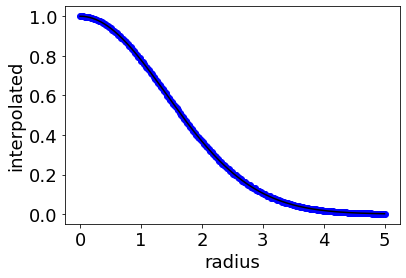

In [221]:
plt.plot(savg.grid1d,savg.y_avgd,'bo')
plt.plot(savg.grid1d,savg.y_monopole,'k-')
#plt.xlim(0,0.25)
#plt.ylim(0.,0.2)
plt.xlabel('radius')
plt.ylabel('interpolated')
plt.savefig('interpolation_test.png',bbox_inches='tight')

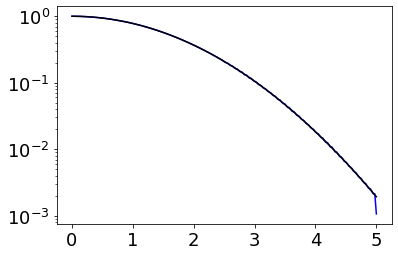

In [222]:
plt.semilogy(savg.grid1d,savg.y_avgd,'b-')
plt.plot(savg.grid1d,savg.y_monopole,'k-')
#plt.xlim(2.25,2.75)
#plt.ylim(0.,0.2)

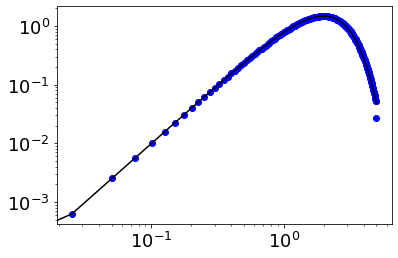

In [223]:
plt.loglog(savg.grid1d,savg.grid1d*savg.grid1d*savg.y_avgd,'bo')
plt.plot(savg.grid1d,savg.grid1d*savg.grid1d*savg.y_monopole,'k-')

3.075991e-03
2.166541e-02


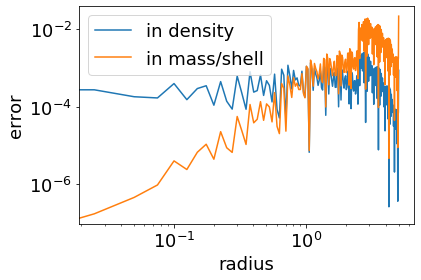

In [224]:
delta_y = savg.y_avgd - savg.y_monopole
err = np.minimum(np.abs(delta_y),np.abs(delta_y)/(savg.y_monopole + 1e-12))
print('%e' % err.max())
plt.loglog(savg.grid1d, err,label='in density')

delta_y = savg.grid1d*savg.grid1d*(savg.y_avgd - savg.y_monopole)
err = np.minimum(np.abs(delta_y),np.abs(delta_y)/(savg.grid1d*savg.grid1d*savg.y_monopole + 1e-12))
print('%e' % err.max())
plt.loglog(savg.grid1d, err,label='in mass/shell')

plt.xlabel('radius')
plt.ylabel('error')
plt.legend()
plt.savefig('density_v_mass_in_shell.png',bbox_inches='tight')

In [225]:
mass_avgd = integrate.trapz(4*np.pi*savg.grid1d**2*savg.y_avgd,x=savg.grid1d)
mass_orig = integrate.trapz(4*np.pi*grid1d**2*savg.y_monopole,x=grid1d)
print("%e %e %e" % (mass_avgd, mass_orig, (mass_avgd - mass_orig)/mass_orig))

4.427883e+01 4.428584e+01 -1.581947e-04


In [226]:
%pwd

'/home/jonahm/programming/phoebus/scripts/jupyter'

Generating grids
Generating functions
Interpolating
Done
0.004037420839303539
Generating grids
Generating functions
Interpolating
Done
0.0006073583396909055
Generating grids
Generating functions
Interpolating
Done
-5.286721775568324e-05


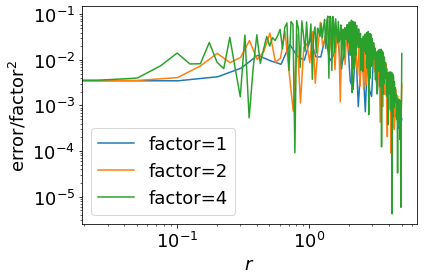

In [227]:
n1d_base = 50
nblk_base = 16
max_errs = []
mass_errs = []
resfacs = [1,2,4]
for resfac in resfacs:
    savg = SphericalAverage(5, n1d_base*resfac, 
                            [nblk_base*resfac,nblk_base*resfac,nblk_base*resfac], 
                            [2, 2, 2], sigma = 1)
                            #[[0,0,0],[0,1,0],[0,0,1],[0,1,1]])
    delta_y = savg.y_avgd - savg.y_monopole
    err = np.minimum(np.abs(delta_y),np.abs(delta_y)/(savg.y_monopole + 1e-12))
    max_errs.append(err.max())
    mass_avgd = integrate.trapz(4*np.pi*savg.grid1d**2*savg.y_avgd,x=savg.grid1d)
    mass_orig = integrate.trapz(4*np.pi*savg.grid1d**2*savg.y_monopole,x=savg.grid1d)
    mass_errs.append((mass_avgd - mass_orig)/mass_orig)
    print(mass_errs[-1])
    plt.loglog(savg.grid1d, (resfac**2)*err,label=f'factor={resfac}')
    #plt.plot(savg.grid1d, err,label=f'factor={resfac}')
plt.legend()
plt.xlabel(r'$r$')
plt.ylabel(r'error$/$factor$^2$')
#plt.ylim(1e-6,1e-1)

plt.savefig('interpolation_error_gaussian_spherical_3d_multiblock.png',
            bbox_inches='tight',
            dpi=300)

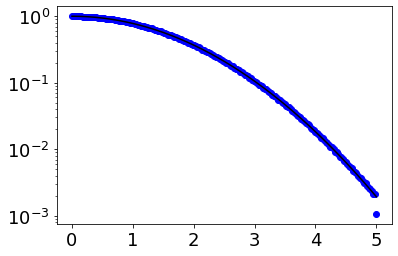

In [228]:
plt.semilogy(savg.grid1d,savg.y_avgd,'bo')
plt.plot(savg.grid1d,savg.y_monopole,'k-')

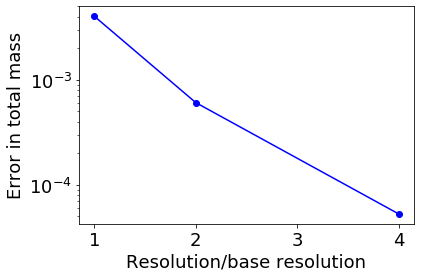

In [229]:
plt.semilogy(resfacs,np.abs(mass_errs),'bo-')
plt.xlabel('Resolution/base resolution')
plt.ylabel('Error in total mass')
plt.savefig('interpolation_mass_error_amr_spherical_3d_multiblock.png',bbox_inches='tight',dpi=300)

In [230]:
mass_errs

[0.004037420839303539, 0.0006073583396909055, -5.286721775568324e-05]